# Class 1 — Similarity, High Dimensions, and Why PCA

**Big idea:** most supervised learning methods rely (explicitly or implicitly) on: *similar items have similar outcomes*.

Today we will:
- Make the idea of **similarity** concrete (via distances)
- See why similarity becomes tricky in **high dimensions** (curse of dimensionality)
- Motivate **dimensionality reduction** and **PCA**

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 110
%precision 3

'%.3f'

## The Curse of Dimensionality

In your previous supervised learning course, you trained multiple Machine Learning models. All of these models share an implicit assumption:
**Similar** items have **similar** outcomes. 

For example:
- Two apartments similar in location, size, and amenities should have similar prices
- Used cars of similar age should have similar prices

This seems intuitive, but as we'll see, defining "similar" becomes surprisingly tricky in high dimensions.

To make *similar* mathematically precise, we use **distance** in feature space:

- **Euclidean distance** (most common): straight-line distance, like measuring with a ruler
- **Manhattan distance** (more robust): sum of absolute differences along each dimension, like walking city blocks in Manhattan
- **Cosine distance** (for direction): measures angle between vectors, ranging from 0 (same direction) to 1 (orthogonal)

**Connection to what you know:** Ordinary Least Squares (OLS) regression finds coefficients that minimize the Euclidean *distance* between observed outcomes $y$ and predicted outcomes $\mathbf{X}'\hat \beta$.

**The problem:** As we move into higher dimensions, distance becomes less reliable for expressing similarity. Let's see why.

### Problem 1: Sparsity (everything lives at the edges)

As dimensions increase, data becomes increasingly **sparse**: most points end up near the boundaries rather than in the interior of the space.

**Simple example:** Consider uniformly distributed random points in a [0, 1] box. Define "internal points" as those not within 2% of any edge (i.e., in the range [0.02, 0.98]).

- **1 dimension:** Probability of being internal = 0.96 (96%)
- **2 dimensions:** Probability = 0.96² = 0.92 (92%)
- **3 dimensions:** Probability = 0.96³ = 0.88 (88%)
- **100 dimensions:** Probability = 0.96¹⁰⁰ ≈ 0.017 (less than 2%!)

**Why this matters:** In high-dimensional spaces, almost all data points cluster near the boundaries. This is counterintuitive and makes statistical sampling, clustering, and distance-based algorithms much less effective.

### Problem 2: Distance concentration (everything becomes equidistant)

As dimensionality increases, the average distance between points obviously grows. But here's the counterintuitive part: the **ratio** between the nearest and farthest neighbor approaches 1.
Thus, in very high dimensions, all points become almost equidistant from each other. Your "closest" neighbor isn't really that close anymore!

**Why this matters:** This undermines the fundamental assumption behind many ML algorithms, that nearby points should be more similar than distant ones. If everything is roughly the same distance away, how do we define "similar"?

Let's run a simulation to see this phenomenon in action.

## Seeing the Curse in Action (simulation)

Let's generate random points in spaces of increasing dimensionality (from 1D to 1000D) and observe what happens.

**Setup:** We create 100 random points in a $d$-dimensional unit hypercube $[0,1]^d$ and measure their distances from a fixed query point at the center (0.5, 0.5, ..., 0.5).

**Key questions:**
1. As $d$ increases, what happens to the *minimum* distance (closest point)?
2. What happens to the *maximum* distance (farthest point)?
3. What does this tell us about the ratio between nearest and farthest distances?

**What to look for:** If the curse of dimensionality is real, we should see the minimum distance increasing (nearest neighbors getting farther away), while the ratio between min and max distances shrinks (distances becoming more uniform).

In [2]:
def generate_random_dataset(num_points, num_dimensions):
    # Generate random points uniformly distributed in [0, 1]^n
    return np.random.rand(num_points, num_dimensions)

def calculate_distances(dataset, query_point):
    # calculate Euclidean distances in an efficient way
    return np.linalg.norm(dataset - query_point, axis=1)

def run_experiment(dimensions, num_points=100):
    min_distances = []
    max_distances = []
    
    for dim in dimensions:
        # Generate a random dataset and a query point
        dataset = generate_random_dataset(num_points, dim)
        
        # define a query point
        query_point = np.repeat(0.5, dim)
        
        # Calculate distances from the query point
        distances = calculate_distances(dataset, query_point)
        
        # Record the min and max distances
        min_distances.append(np.min(distances))
        max_distances.append(np.max(distances))

    return {'min_distances': min_distances, 'max_distances': max_distances}

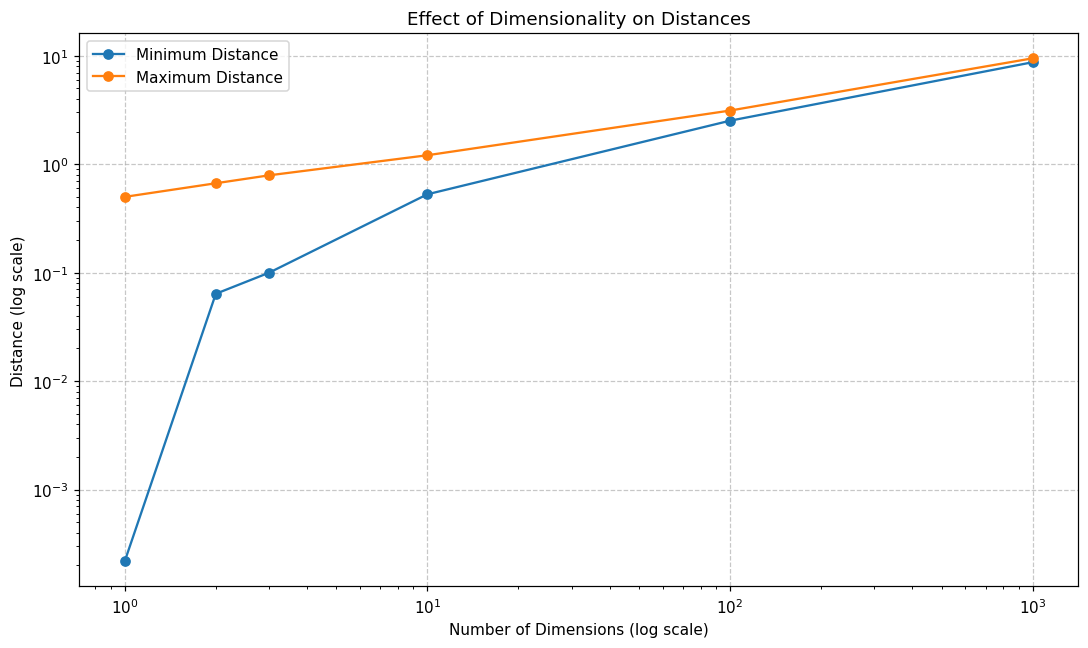

In [3]:
# Run the experiment
dimensions = [1, 2, 3, 10, 100, 1000]
results = run_experiment(dimensions=dimensions)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, results['min_distances'], label='Minimum Distance', marker='o')
plt.plot(dimensions, results['max_distances'], label='Maximum Distance', marker='o')
plt.xlabel("Number of Dimensions (log scale)")
plt.ylabel("Distance (log scale)")
plt.title("Effect of Dimensionality on Distances")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.tight_layout()

**Key observations from the simulation:**
- As $d$ increases, the *minimum* distance grows substantially (your closest neighbor gets farther away)
- The *maximum* distance also grows, but more slowly
- The ratio between min and max distances approaches 1 (everything becomes roughly equidistant)
- In 1000D, there's almost no meaningful difference between "near" and "far"

**The bottom line:** Adding more features doesn't always help! Beyond some point, it actually makes our notion of "similarity" less useful.

**The solution:** **Dimensionality reduction** -> intelligently compress high-dimensional data into fewer dimensions while preserving the important structure. This is where PCA comes in.